In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import colorsys
import os
from tqdm import tqdm 
import requests
import colorsys
import zipfile
from sklearn.metrics import silhouette_score
import shutil

In [32]:
def kmeans_color_quantization(image):
    image_np = np.array(image)   
    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    pixels = hsv_image.reshape((-1, 3))
    pixels = np.float32(pixels)
    

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.002)
    best_score = float('inf')
    best_k = 2
    for k in range(2, 5):
        compactness = cv2.kmeans(pixels, k, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)[0]
        if compactness < best_score:
            best_score = compactness
            best_k = k
    

    _, labels, centers = cv2.kmeans(pixels, best_k, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
    labels_2d = labels.reshape(hsv_image.shape[:2])
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(hsv_image.shape)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_HSV2RGB)

    return segmented_image, labels_2d, centers


def recolor_cluster(image, labels, cluster_numbers, hue, saturation):

    recolored_image = np.array(image)
    hsv = plt.cm.colors.rgb_to_hsv(recolored_image[:, :, :3] / 255.)
    cluster_mask = np.isin(labels, cluster_numbers)
    hsv[cluster_mask, 0] = hue
    hsv[cluster_mask, 1] = saturation
    rgb = plt.cm.colors.hsv_to_rgb(hsv)
    rgb = (rgb * 255).astype(np.uint8)
    new_image = Image.fromarray(rgb)

    return new_image


In [33]:
def find_nearest_hsv_indices(hsv_array, hsv_value, num_nearest=1):

    hsv_array = np.array(hsv_array, dtype=np.float32)
    hue = (hsv_value[0] / 360) * 179
    saturation = hsv_value[1] * 255
    value = hsv_value[2] * 255 if len(hsv_value) > 2 else 0

    transformed_hsv_value = np.array([hue, saturation, value], dtype=np.float32)
    distances = np.linalg.norm(hsv_array[:, :2] - transformed_hsv_value[:2], axis=1)
    nearest_indices = np.argsort(distances)[:num_nearest]

    return nearest_indices

In [34]:
def read_image(image_path):
    return Image.open(image_path)


In [40]:
directory = '/kaggle/working/'

# Удаление файлов
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')


In [1]:
input_dir = '/kaggle/input/lct-dataset/banner first training renamed/banner first training renamed'
output_dir = '/kaggle/working/processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, filename)
        image = read_image(image_path)
        
        quantized_image, labels, centers = kmeans_color_quantization(image)
        cluster_number = find_nearest_hsv_indices(centers, [223/360, 0.87], num_nearest=1)
        recolored_cluster_image = recolor_cluster(image, labels, cluster_numbers=cluster_number, hue=223/360, saturation=0.87)
        output_path = os.path.join(output_dir, filename)
        recolored_cluster_image.save(output_path)


zip_path = '/kaggle/working/processed_images.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), file)

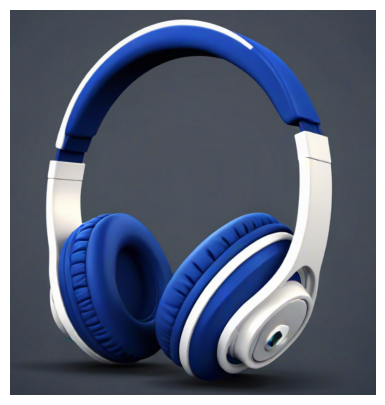

In [4]:
# 28°, 81%, 98%
quantized_image, labels, centers = kmeans_color_quantization(image, k=3)
cluster_number = find_nearest_hsv_indices(centers, [28, 0.81], num_nearest=1)
recolored_cluster_image = recolor_cluster(image, labels, cluster_numbers=cluster_number, hue=28/360, saturation=0.81)
recolored_cluster_image

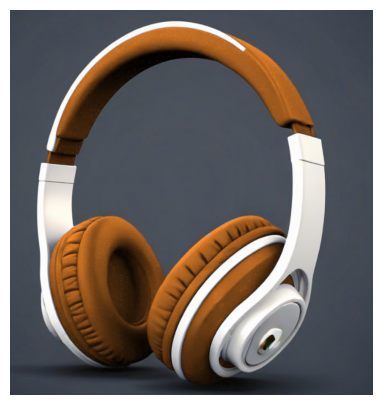

In [3]:
image